ME200, Johannes Ruf and Luitgard Veraart

# Day 11: Option pricing with variance reduction methods in Python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
rng = np.random.default_rng(12345)

For comparison purpose we reuse the functions that compute the analytical time-$0$ price of a European call option using the Black-Scholes option pricing formula and the function that approximates this price using a standard Monte Carlo estimator from the previous notbook. 


In [3]:
def black_scholes_call(S0, K, r, T, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T)/(sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    tmp1 = S0 * norm.cdf(d1, loc=0, scale=1)
    tmp2 = K * np.exp(-r * T) * norm.cdf(d2, loc=0, scale=1)
    price = tmp1 - tmp2
    return price

def terminal_stockprice(rng, S0, T, r, sigma, samplesize):
    mystandardnormalsample = rng.standard_normal(size=samplesize)
    tmp1 = (r - 0.5*(sigma ** 2)) * T
    tmp2 = sigma * np.sqrt(T) * mystandardnormalsample
    stockprice = S0 * np.exp(tmp1 + tmp2)
    return stockprice

def bs_call_mc(rng, S0, K, T, r, sigma, samplesize, myepsilon):
    # Generate terminal stock prices.
    mystockprice = terminal_stockprice(rng, S0, T, r, sigma, samplesize)
    # Compute payoffs.
    payoffs = np.maximum(mystockprice - K, 0)
    # Discount payoffs
    discountedpayoffs = np.exp(- r * T)*payoffs
    # Compute MC price
    price = np.mean(discountedpayoffs)
    # Compute confidence interval next
    standarddev_rv = np.std(discountedpayoffs, ddof=1)
    standarddev_mcest = standarddev_rv / np.sqrt(samplesize)
    aepsilon = norm.ppf(1.0 - myepsilon * 0.5)
    # Left boundary of CI
    ci_left = price - aepsilon * standarddev_mcest
    # Right boundary of CI
    ci_right = price + aepsilon * standarddev_mcest
    return price, standarddev_mcest, ci_left, ci_right

We consider one example for different estimators. 

In [4]:
# Defining some model parameters
S0 = 50.0
K = 50.0
T = 0.25
r = 0.05
sigma = 0.3
halfsamplesize = 100000
samplesize = 2 * halfsamplesize
myepsilon = 0.05

In [5]:
print('----------------')
print('The analytical option price is {:.4f}'.format(black_scholes_call(S0, K, r, T, sigma)))
print('-----------------')
MCresults = bs_call_mc(rng, S0, K, T, r, sigma, samplesize, myepsilon)
print('MC price: {:.4f} and stdev of MC est: {:.4f}'.format(MCresults[0], MCresults[1]))
print('CI based on MC is ({:.4f}, {:.4f})'.format(MCresults[2], MCresults[3]))


----------------
The analytical option price is 3.2915
-----------------
MC price: 3.2909 and stdev of MC est: 0.0112
CI based on MC is (3.2691, 3.3128)


Note, that we multiplied the sample size by 2 above, to be able to make a fair comparison with the antithetic variate estimator later. 

## Control variates to price a European call in the Black-Scholes model

In [6]:
def bs_call_cv(rng, S0, K, T, r, sigma, samplesize, myepsilon):
    """ Control variate estimation for European call price in BS model."""
    # Generate terminal stock prices.
    mystockprice = terminal_stockprice(rng, S0, T, r, sigma, samplesize)
    # Compute payoffs.
    payoffs = np.maximum(mystockprice - K, 0)
    # Discount payoffs
    discountedpayoffs = np.exp(- r * T)*payoffs
    # Use discounted stock as control
    xs = np.exp(- r * T) * mystockprice
    # Compute sample version of b*
    bstar = np.cov(xs, discountedpayoffs, ddof=1)[0, 1] / np.var(xs, ddof=1)
    # print("In cv bstar=", bstar)
    # Define z= Y(bstar)
    z = discountedpayoffs - bstar * (xs - S0)
    # Compute MC price
    price = np.mean(z)
    # Compute confidence interval next
    standarddev_rv = np.std(z, ddof=1)
    standarddev_cvest = standarddev_rv / np.sqrt(samplesize)
    aepsilon = norm.ppf(1.0 - myepsilon * 0.5)
    # Left boundary of CI
    ci_left = price - aepsilon * standarddev_cvest
    # Right boundary of CI
    ci_right = price + aepsilon * standarddev_cvest
    # Compute the squared correation rhosquared
    tmpcov = np.cov(xs, discountedpayoffs, ddof=1)[0, 1]
    tmpvarx = np.var(xs, ddof=1)
    tmpvary = np.var(discountedpayoffs, ddof=1)
    rhosquared = (tmpcov ** 2) / (tmpvarx * tmpvary)
    return price, standarddev_cvest, ci_left, ci_right, rhosquared

In [7]:
print('----------------')
CVresults = bs_call_cv(rng, S0, K, T, r, sigma, samplesize, myepsilon)
print('CV price: {:.4f} and stdev of CV est {:.4f}:'.format(CVresults[0], CVresults[1]))
print('CI based on CV is ({:.4f}, {:.4f})'.format (CVresults[2], CVresults[3]))
print('Note that rhosquared is {:.4f}'.format(CVresults[4]))

----------------
CV price: 3.2919 and stdev of CV est 0.0050:
CI based on CV is (3.2822, 3.3017)
Note that rhosquared is 0.8016


### Sensitivity of the correlation in the CV estimator with respect to the strike

We consider the sensitivity of rho and rhosquared related to the control
variate estimator with respect to the strike price.
We consider the same model parameters as in Glasserman(2004; p. 189) and will reproduce the results reported there. 

In [8]:
S0 = 50
T = 0.25
r = 0.05
sigma = 0.3
samplesize = 200000
numberofk = 100
strikes = np.linspace(start=0, stop=80, num=numberofk)
rhosquared = np.zeros(numberofk)
rho = np.zeros(numberofk)

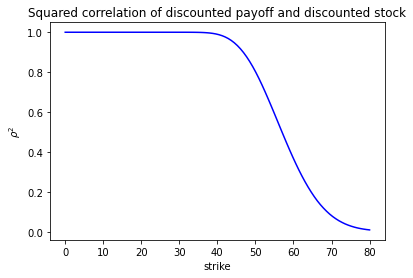

In [9]:
# Generate stockprice
myst = terminal_stockprice(rng, S0, T, r, sigma, samplesize)
mystockprice = myst

for i in range(numberofk):
    k = strikes[i]
    # Compute payoffs.
    payoffs = np.maximum(mystockprice - k, 0)
    # Discount payoffs
    discountedpayoffs = np.exp(- r * T)*payoffs
    # Define variable y for control variate estimator
    ys = discountedpayoffs
    # Use discounted stock as control
    xs = np.exp(- r * T) * mystockprice
    rho[i] = np.corrcoef(xs, ys)[0, 1]
    rhosquared[i] = rho[i] ** 2

fig, ax = plt.subplots()
ax.plot(strikes, rhosquared, c="blue")
ax.set_xlabel("strike")
ax.set_ylabel(r"$\rho^2$")
ax.set_title("Squared correlation of discounted payoff and discounted stock")
plt.show() 

Hence, we see that for small strikes there is a strong correlation between the discounted payoff and the discounted stock price, but this decreases significantly for larger strikes. 

## Antithetic variates to price a European call in the Black-Scholes model
We consider the antithetic pair $(X, -X)$ where  $X\sim \mathcal{N}_1(0, 1)$. For the stock price this implies that we consider pairs of the form $(S^{(1)}, S^{(2)})$, where
\begin{align*}
S^{(1)} & = S_0 \exp( (r - 0.5 \sigma^2) T + \sigma \sqrt{T} X), \\
S^{(2)} & = S_0 \exp( (r - 0.5 \sigma^2) T + \sigma \sqrt{T} (-X)) 
\end{align*}
and we will use them to compute the corresponding discounted payoffs. 

In [10]:
def terminal_stockprice_av(rng, S0, T, r, sigma, halfsamplesize):
    """Function computes terminal stock prices based on antithetic pairs. """
    mynormals1 = rng.standard_normal(halfsamplesize)
    mynormals2 = - mynormals1
    tmp1 = (r - 0.5*sigma ** 2) * T
    tmp2 = sigma * np.sqrt(T) * mynormals1
    tmp3 = sigma * np.sqrt(T) * mynormals2
    stockprice1 = S0 * np.exp(tmp1 + tmp2)
    stockprice2 = S0 * np.exp(tmp1 + tmp3)
    allstockprices = np.concatenate((stockprice1, stockprice2))
    return stockprice1, stockprice2, allstockprices

In [11]:
def bs_call_av(rng, S0, K, T, r, sigma, halfsamplesize, myepsilon):
    """ Antithethic variate estimation for European call price in BS model."""
    # Note that 2*halfsamplesize random variables will be used in the AV estimator.
    # Generate terminal stock prices.
    mystockprices = terminal_stockprice_av(rng, S0, T, r, sigma, halfsamplesize)
    # Compute payoffs.
    payoffs1 = np.maximum(mystockprices[0] - K, 0)
    payoffs2 = np.maximum(mystockprices[1] - K, 0)
    # Discount payoffs
    discpayoffs1 = np.exp(- r * T)*payoffs1
    discpayoffs2 = np.exp(- r * T)*payoffs2
    thecov = np.cov(discpayoffs1, discpayoffs2, ddof=1)[0, 1]
    possiblereduction = thecov / (2 * halfsamplesize)
    discpayoffs = np.concatenate((discpayoffs1, discpayoffs2))
    price = np.mean(discpayoffs)
    standarddev_rv = np.std(discpayoffs, ddof=1)
    standarddev_avest = standarddev_rv / np.sqrt(2*halfsamplesize)
    aepsilon = norm.ppf(1.0 - myepsilon * 0.5)
    ci_left = price - aepsilon * standarddev_avest
    ci_right = price + aepsilon * standarddev_avest
    return price, standarddev_avest, ci_left, ci_right, possiblereduction

In [12]:
print('----------------')
AVresults = bs_call_av(rng, S0, K, T, r, sigma, halfsamplesize, myepsilon)
print('AV price: {:.4f} and stdev of AV est {:.4f}:'.format(AVresults[0], AVresults[1]))
print('CI based on AV is ({:.4f}, {:.4f})'.format(AVresults[2], AVresults[3]))
print('Note that sample covariance/(2n) is {:.4f}'.format(AVresults[4]))

----------------
AV price: 3.2916 and stdev of AV est 0.0112:
CI based on AV is (3.2698, 3.3135)
Note that sample covariance/(2n) is -0.0001


We see that the AV estimate is very close to the analytical option price. In this example, we see that $cov(Z^{(1)}, Z^{(2)})/2n$, where
\begin{align*}
Z^{(1)}& = e^{-rT} \left(S_0 \exp( (r - 0.5 \sigma^2) T + \sigma \sqrt{T} X) - K \right)^+, \\
Z^{(2)}& = e^{-rT} \left(S_0 \exp( (r - 0.5 \sigma^2) T + \sigma \sqrt{T} (-X)) - K \right)^+, 
\end{align*}
is negative but very close to zero. 